In [1]:
import sys
import numpy as np
import scipy
import subprocess
from natsort import natsorted
import itertools
import pandas as pd
sys.path.append("../utls")
sys.path.append("../utls")
sys.path.append("../.")
import os
from utls.preprocessing import *
from utls.postprocessing import *
from InterfaceDeclaration import LPBFInterface
import matplotlib.pyplot as plt
import seaborn as sns

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
process_regime = [
    [0,    59, "Base"  ], 
    [60,  129, "KH"    ], 
    [130, 199, "Normal"], 
    [200, 269, "RLoF"  ], 
    [269, 339, "LoF"   ] 
]

## Accuracy results

In [5]:
max_epochs=50
his_dir = os.path.join(os.pardir,"lfs","weights/hist")
model_name= ["CNN"]
acoustic_type =['ae','mic'] 
context_type = []
# context_type = ['energy']
output_type = ['direction']
folds = 10

df = generate_hist_df(his_dir,model_name,acoustic_type,context_type,output_type,folds,max_epochs)
df['Input Type'] = df['Input type'].str.replace('+', '\n')

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_21284\3195546150.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_21284\3195546150.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]])
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_21284\3195546150.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in xTickLabels])


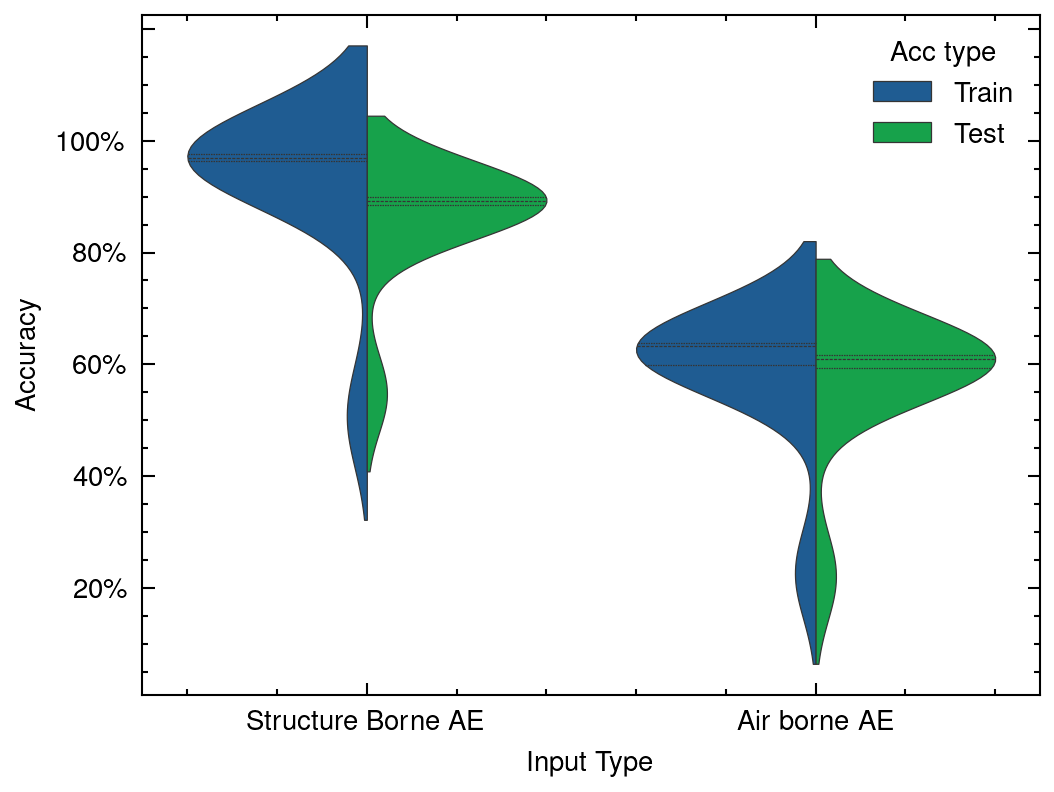

In [6]:
plt.rcParams.update(one_column)
plt.rcParams['figure.constrained_layout.use'] = True
fig,ax = plt.subplots()
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[df["Model"]=="CNN"],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax,
    linewidth=0.3,
    palette = ['#0C5DA5', '#00B945', 'yellow'],
)
ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]]) 
xTickLabels = ["Structure Borne AE","Air borne AE"]
ax.set_xticklabels([x for x in xTickLabels]) 
ax.set_ylabel("Accuracy")
plt.savefig(f"../outputs/raw_acc_ae_mic_direction.png",dpi=300)
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[(df["Model"]=="CNN") & df["Input Type"].str.contains("ae")],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[(df["Model"]=="CNN") & df["Input Type"].str.contains("mic")],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[df["Model"]=="SVM"],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[(df["Model"]=="SVM") & df["Input Type"].str.contains("ae")],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[(df["Model"]=="SVM") & df["Input Type"].str.contains("mic")],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax
)